In [1]:
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy
import random
import gym
import scipy
import pickle

# Common functions

In [24]:
# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array, 0.9))

In [20]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)

        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//nproc)):
            env.step(env.action_space.sample())
        return env
    return _f

# Global variables

In [4]:
env_name = "CartPole-v1"
pi_learning_rate = 3e-4
v_learning_rate = 3e-4
discount_factor = 0.98
lambda_factor = 0.96

iterations = 500000
batch_size = 128
history_size = 128

nproc = 40
envs = DummyVecEnv([make_env(env_name, seed) for seed in range(nproc)]) #Dummy
        
# This code gets action and observation space sizes for 1D tasks
action_space_size = envs.action_space.n if isinstance(envs.action_space, gym.spaces.discrete.Discrete) else envs.action_space.shape[0]
observation_space_size = envs.observation_space.n if isinstance(envs.observation_space, gym.spaces.discrete.Discrete) else envs.observation_space.shape[0]

C:\Users\suriknik\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
logger = {
    "actor_loss": [],
    "actor_gradients_max_abs": [],
    "actor_gradients_equal_zero": [],
    "critic_loss": [],
    "critic_gradients_max_abs": [],
    "critic_gradients_equal_zero": [],
    "value_mean": [],
    "reward": [],
    "adv_mean": [],
    "actions_max": [],
}

## Neural net configuration

In [6]:
EPS = 1e-8
def gaussian_likelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x-mu)/(tf.exp(log_std)+EPS))**2 + 2*log_std + np.log(2*np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [7]:
tf.reset_default_graph()
sess = tf.Session()

In [8]:
class ActorNetwork():
    def __init__(self):
        var_scope_name = "actor/"
        with tf.variable_scope(var_scope_name):
            self.input_state = tf.placeholder(tf.float32, shape=(None, observation_space_size), name="input_state")
            self.l1 = tf.layers.dense(self.input_state, units=100, activation=tf.tanh)
            self.l2 = tf.layers.dense(self.l1, units=50, activation=tf.tanh)
            self.l3 = tf.layers.dense(self.l2, units=25, activation=tf.tanh)
            self.output_layer = tf.layers.dense(self.l3, units=action_space_size)

            log_std = tf.get_variable(name='log_std', initializer=-0.5*np.ones(action_space_size, dtype=np.float32))
            std = tf.exp(log_std)

            self.action_op = self.output_layer + tf.random_normal(shape=tf.shape(self.output_layer)) * std
            
            # Training
            self.action_ph = tf.placeholder(tf.float32, shape=(None, action_space_size), name="action_ph")
            self.adv_ph = tf.placeholder(tf.float32, shape=(None), name="adv_ph")

            self.logp = gaussian_likelihood(self.action_ph, self.output_layer, log_std)
            self.loss = -tf.reduce_mean(self.adv_ph * self.logp)
            
            self.gradients = tf.gradients(self.loss, [t_var for t_var in tf.trainable_variables() if var_scope_name in t_var.name]) # For Debug!
            self.train_op = tf.train.AdamOptimizer(pi_learning_rate).minimize(self.loss)

In [9]:
class DiscreteActorNetwork():
    def __init__(self):
        var_scope_name = "discrete_actor/"
        with tf.variable_scope(var_scope_name):
            self.input_state = tf.placeholder(tf.float32, shape=(None, observation_space_size), name="input_state")
            self.l1 = tf.layers.dense(self.input_state, units=100, activation=tf.tanh)
            self.l2 = tf.layers.dense(self.l1, units=50, activation=tf.tanh)
            self.l3 = tf.layers.dense(self.l2, units=25, activation=tf.tanh)
            self.output_layer = tf.layers.dense(self.l3, units=action_space_size)

            self.action_ph = tf.placeholder(tf.int32, shape=(None), name="action_ph")
            self.adv_ph = tf.placeholder(tf.float32, shape=(None), name="adv_ph")
            self.action_mask = tf.one_hot(self.action_ph, action_space_size)

            self.action_op = tf.squeeze(tf.multinomial(logits=self.output_layer, num_samples=1), axis=1)

            self.logp = tf.reduce_sum(self.action_mask * tf.nn.log_softmax(self.output_layer), axis=1)
            self.loss = -tf.reduce_mean(self.adv_ph * self.logp)
            
            self.gradients = tf.gradients(self.loss, [t_var for t_var in tf.trainable_variables() if var_scope_name in t_var.name]) # For Debug!
            self.train_op = tf.train.AdamOptimizer(pi_learning_rate).minimize(self.loss)

In [10]:
class CriticNetwork():
    def __init__(self):
        var_scope_name = "critic/"
        with tf.variable_scope(var_scope_name):
            self.input_state = tf.placeholder(tf.float32, shape=(None, observation_space_size))
            self.l1 = tf.layers.dense(self.input_state, units=64, activation=tf.nn.tanh)
            self.output_layer = tf.layers.dense(self.l1, units=1)

            self.target_value_ph = tf.placeholder(tf.float32, shape=(None), name="target_value_ph")
            self.get_v_op = tf.squeeze(self.output_layer, axis=1)

            self.loss = tf.losses.mean_squared_error(self.target_value_ph, self.get_v_op)            
            self.gradients = tf.gradients(self.loss, [t_var for t_var in tf.trainable_variables() if var_scope_name in t_var.name]) # For Debug!
            self.train_op = tf.train.AdamOptimizer(v_learning_rate).minimize(self.loss)

In [11]:
actor_net = DiscreteActorNetwork()
critic_net = CriticNetwork()
sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

W0722 16:43:32.905462  2356 deprecation.py:323] From <ipython-input-9-3b92ee0c82fc>:6: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0722 16:43:32.925467  2356 deprecation.py:506] From C:\Users\suriknik\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 16:43:33.360443  2356 deprecation.py:323] From <ipython-input-9-3b92ee0c82fc>:15: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.random.categorical` instead.
W0722 16:43:33.795438  2356 deprecation.py:323] From C:\Users\suriknik\Anaconda3\lib\site-packages\tens

# Batch generator

In [12]:
def reward_to_go(rews):
    return np.cumsum(rews[::-1])[::-1]

In [13]:
def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

In [14]:
def estimate_advantage(states, rewards):
    values = sess.run(critic_net.get_v_op, feed_dict={critic_net.input_state: states})
    deltas = rewards - values
    deltas = deltas + discount_factor * np.append(values[1:], np.array([0]))
    
    advantage = discount_cumsum(deltas, lambda_factor * discount_factor)
    
#     gamma_labda_powers = [(discount_factor * lambda_factor) ** l for l in range(len(states))]
#     advantage2 = np.zeros_like(rewards)
#     for t in range(len(values)):
#         for l in range(len(states) - t): # We have finite sum case
#             advantage2[t] += gamma_labda_powers[l] * deltas[t + l]
    return advantage, values

In [15]:
def batch_generator(batch_size, history_size):
    """
        history[0] = state
        history[1] = action
        history[2] = reward / advantage
        histpry[3] = reward-to-go
    """
    history = np.empty((0, 4))
    trajectories = [np.empty((0, 4)) for _ in range(nproc)] # creating trajectory for each process
    observations = np.array([[0 for i in range(observation_space_size)] for j in range(nproc)]) #envs.reset()
    
    while True:
        history = history[batch_size:]
        while len(history) < history_size:
            observations_old = observations
            actions = sess.run((actor_net.action_op), feed_dict={
                    actor_net.input_state: observations_old,
                })
            logger["actions_max"].append(actions.max())
            observations, rewards, dones, _ = envs.step(actions)
            
            for pid in range(nproc):
                trajectories[pid] = np.vstack((trajectories[pid], [observations_old[pid], actions[pid], rewards[pid], None]))
                
                if dones[pid]:
                    if len(trajectories[pid]) > 2:
                        input_states = np.array(np.array(trajectories[pid][:, 0].tolist()))
                        logger["reward"].append(trajectories[pid][:, 2].sum())
                        trajectories[pid][:, 3] = discount_cumsum(trajectories[pid][:, 2], discount_factor)
                        trajectories[pid][:, 2], values = estimate_advantage(input_states, trajectories[pid][:, 2])
                        logger["adv_mean"].append(trajectories[pid][:, 2].sum())
                        logger["value_mean"].append(values.mean())
                        history = np.vstack((history, trajectories[pid]))
                    trajectories[pid] = np.empty((0, 4))
            
        np.random.shuffle(history)
        history = history[:history_size]
        yield history[:batch_size]

# Main cycle

In [16]:
max_reward = -1e9

In [27]:
batch_gen = batch_generator(batch_size, history_size)
saver = tf.train.Saver()

for i in tqdm_notebook(range(iterations)):
    batch = next(batch_gen)
    
    input_state = batch[:, 0].tolist()
    
    _, actor_loss, actor_gradients, _, critic_loss, critic_gradients = sess.run (
        (actor_net.train_op, actor_net.loss, actor_net.gradients,
         critic_net.train_op, critic_net.loss, critic_net.gradients), feed_dict={
                actor_net.input_state: input_state,
                actor_net.action_ph: batch[:, 1].tolist(),
                actor_net.adv_ph: batch[:, 2],
                critic_net.input_state: input_state,
                critic_net.target_value_ph: batch[:, 3],
            })
    
    logger["actor_loss"].append(actor_loss)
    logger["actor_gradients_max_abs"].append(np.max([np.max(np.abs(var_grad)) for var_grad in actor_gradients]))
    logger["actor_gradients_equal_zero"].append(len(actor_gradients[actor_gradients == 0]))
    logger["critic_loss"].append(critic_loss)
    
    ################ Saving progress #################
    last_mean_reward = np.array(logger["reward"][-10:]).mean()
    if last_mean_reward > max_reward:
        max_reward = last_mean_reward
        save_path = saver.save(sess, f"./models/A2C/{env_name}/sess/reward({int(max_reward)}).ckpt")
        
        with open("./models/A2C/{}/history.file".format(env_name), "wb") as f:
            pickle.dump(logger, f)
        
        print(f"Model saved in path {save_path}")
    ##################################################

KeyboardInterrupt: 

# Plotting

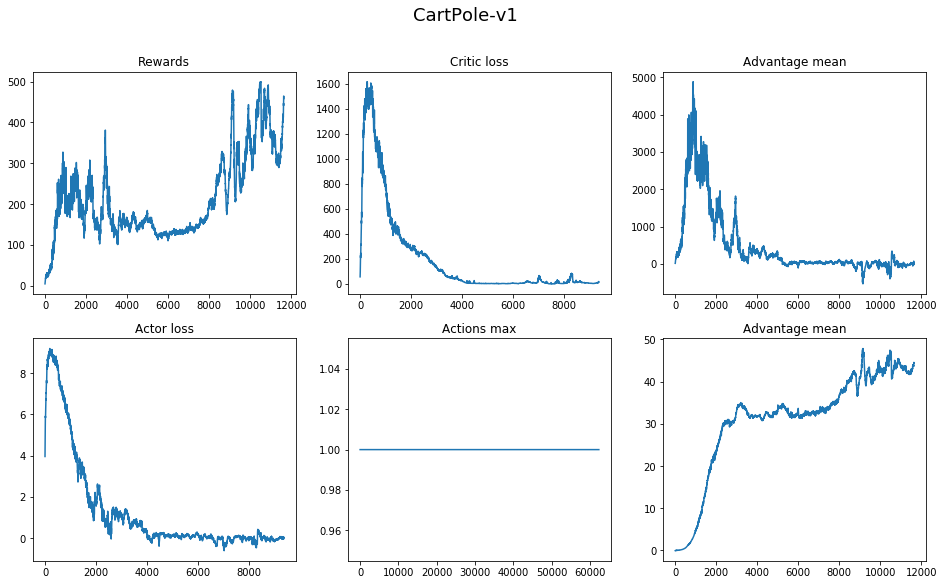

In [28]:
%matplotlib inline
#************ Plotting debug info ****************
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(logger["reward"], "Rewards", axs[0, 0])
plot(logger["critic_loss"], "Critic loss", axs[0, 1])
plot(logger["adv_mean"], "Advantage mean", axs[0, 2])
plot(logger["actor_loss"], "Actor loss", axs[1, 0])
plot(logger["actions_max"], "Actions max", axs[1, 1])
plot(logger["value_mean"], "Advantage mean", axs[1, 2])
plt.suptitle(env_name, fontsize=18)
plt.savefig("./models/A2C/{}/plots/reward({}).png".format(env_name, int(np.array(logger['reward'][-10:]).mean())))
#*************************************************

In [30]:
env = gym.make(env_name)
observation = env.reset()
while True:
    try:
        action = sess.run((actor_net.action_op), feed_dict={
            actor_net.input_state: [observation],
        })
        observation, reward, done, _ = env.step(action[0])
        env.render()
        
        if done:
            env.reset()
    except KeyboardInterrupt:
        env.close()
        break
env.close()

In [26]:
envs.close()
envs = DummyVecEnv([make_env(env_name, seed) for seed in range(nproc)]) #Dummy

C:\Users\suriknik\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
